In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.models import Model
from keras.layers import Input, Conv2D
from keras.layers import MaxPooling2D as KMaxPooling2D
from keras.utils import np_utils
 
from deconvnet.deconv2D import Deconv2D
from deconvnet.pool_unpool import MaxPooling2D, UndoMaxPooling2D
from deconvnet.forward_backward import truncated_model, backward_network

Using TensorFlow backend.


## Import images

Original images :

In [3]:
cat = plt.imread("images/cat.jpg")
cat2 = plt.imread("images/cat2.jpeg")
tree = plt.imread("images/tree.jpg")
car = plt.imread("images/car.jpg")

Images cropped to fit into VGG16 (224, 224) :

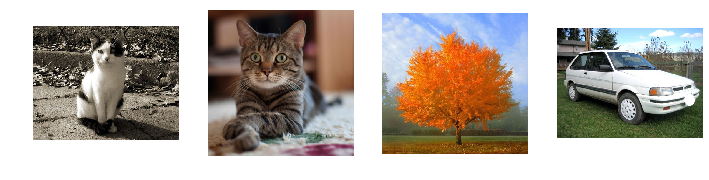

In [4]:
plt.figure(figsize=(12,4))
for i, img in enumerate([cat, cat2, tree, car]):
    plt.subplot(1, 4, i+1)
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [5]:
print(cat.shape, cat2.shape, tree.shape, car.shape)

(393, 500, 3) (380, 380, 3) (528, 545, 3) (360, 480, 3)


In [6]:
car3 = cv2.resize(car, (224, 224))

## Define the networks

We define the VGG network according to the picture we want to analyze :

In [7]:
def build_vgg16(img=None):
    if img is None:
        shape = None
        top = True
    else:
        shape = img.shape
        top = False
    vgg16 = VGG16(include_top=top, weights="imagenet", input_tensor=None,
               input_shape=shape, pooling=None, classes=1000)
    return vgg16

In [38]:
vgg16 = build_vgg16()
tree2 = cv2.resize(tree, (224, 224))
car2 = cv2.resize(car, (224, 224))
pred = vgg16.predict(car2[None])
decode_predictions(pred)

[[('n03770679', 'minivan', 0.738289),
  ('n02814533', 'beach_wagon', 0.07508883),
  ('n04065272', 'recreational_vehicle', 0.035564322),
  ('n03769881', 'minibus', 0.034295417),
  ('n03930630', 'pickup', 0.03163838)]]

In [15]:
main_img = cat2
vgg16 = build_vgg16(main_img)

## Reverse propagation for sample filters

In [16]:
network1 = truncated_model(vgg16, "block1_conv2") # Last convolutional layer
reverse_net1 = backward_network(network1)

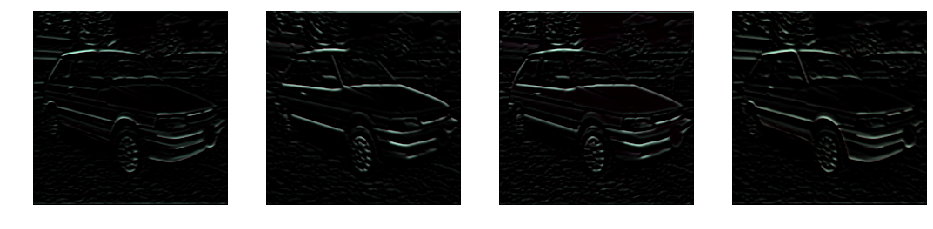

In [154]:
forward_output = network1.predict(main_img[None])
_, _, _, filters = forward_output.shape
f0 = forward_output
best = forward_output[0,:,:,:].max(axis=(0,1)).argsort()[:-5:-1] # Get the k best activations

plt.figure(figsize=(16,4))
for j, i in enumerate(best):
    forward_output = np.zeros_like(f0)
    forward_output[:, :, :, i] = f0[:, :, :, i]
    backward_output = reverse_net1.predict(forward_output)
    img = (backward_output)[0]/(backward_output)[0].max()
    plt.subplot(1,4,j+1)
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [17]:
network2 = truncated_model(vgg16, "block2_conv2") # Last convolutional layer
reverse_net2 = backward_network(network2)

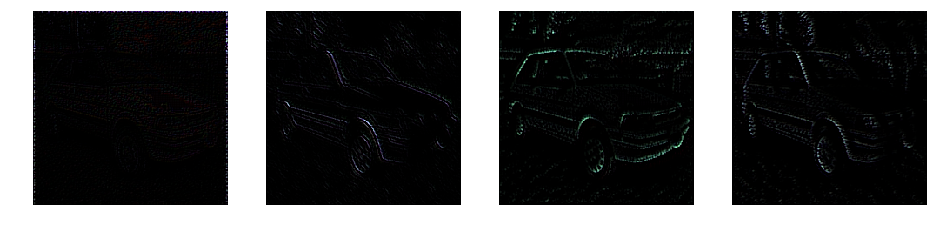

In [156]:
forward_output = network2.predict(main_img[None])
_, _, _, filters = forward_output[0].shape
f0 = forward_output[0]
best = forward_output[0][0,:,:,:].max(axis=(0,1)).argsort()[:-5:-1] # Get the k best activations

plt.figure(figsize=(16,4))
for j, i in enumerate(best):
    forward_output[0] = np.zeros_like(f0)
    forward_output[0][:, :, :, i] = f0[:, :, :, i]
    backward_output = reverse_net2.predict(forward_output)
    img = (backward_output)[0]/(backward_output)[0].max()
    plt.subplot(1,4,j+1)
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [18]:
network3 = truncated_model(vgg16, "block3_conv3") # Last convolutional layer
reverse_net3 = backward_network(network3)

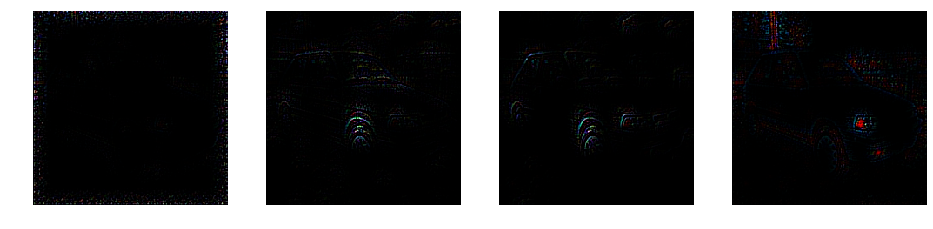

In [158]:
forward_output = network3.predict(main_img[None])
_, _, _, filters = forward_output[0].shape
f0 = forward_output[0]
best = forward_output[0][0,:,:,:].max(axis=(0,1)).argsort()[:-5:-1] # Get the k best activations

plt.figure(figsize=(16,4))
for j, i in enumerate(best):
    forward_output[0] = np.zeros_like(f0)
    forward_output[0][:, :, :, i] = f0[:, :, :, i]
    backward_output = reverse_net3.predict(forward_output)
    img = (backward_output)[0]/(backward_output)[0].max()
    plt.subplot(1,4,j+1)
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [19]:
network4 = truncated_model(vgg16, "block4_conv3") # Last convolutional layer
reverse_net4 = backward_network(network4)

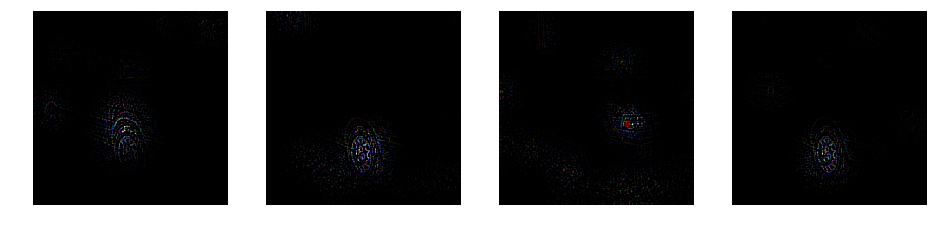

In [160]:
forward_output = network4.predict(main_img[None])
_, _, _, filters = forward_output[0].shape
f0 = forward_output[0]
best = forward_output[0][0,:,:,:].max(axis=(0,1)).argsort()[:-5:-1] # Get the k best activations

plt.figure(figsize=(16,4))
for j, i in enumerate(best):
    forward_output[0] = np.zeros_like(f0)
    forward_output[0][:, :, :, i] = f0[:, :, :, i]
    backward_output = reverse_net4.predict(forward_output)
    img = (backward_output)[0]/(backward_output)[0].max()
    plt.subplot(1,4,j+1)
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [20]:
network5 = truncated_model(vgg16, "block5_conv3") # Last convolutional layer
reverse_net5 = backward_network(network5)

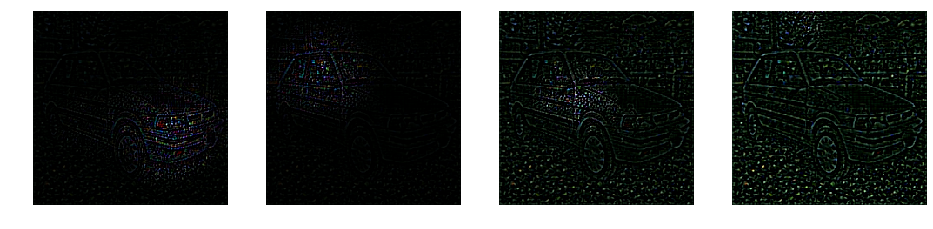

In [162]:
forward_output = network5.predict(main_img[None])
_, _, _, filters = forward_output[0].shape
f0 = forward_output[0]
best = forward_output[0][0,:,:,:].max(axis=(0,1)).argsort()[:-5:-1] # Get the k best activations

plt.figure(figsize=(16,4))
for j, i in enumerate(best):
    forward_output[0] = np.zeros_like(f0)
    forward_output[0][:, :, :, i] = f0[:, :, :, i]
    backward_output = reverse_net5.predict(forward_output)
    img = (backward_output)[0]/(backward_output)[0].max()
    plt.subplot(1,4,j+1)
    plt.axis("off")
    plt.imshow(img)
plt.show()

Aggregate into one plot :

In [21]:
# Third term = interesting filter plots among the 4 best
all_ = [
    [network1, reverse_net1, [0, 1]], 
    [network2, reverse_net2, [3, 2]],
    [network3, reverse_net3, [3, 2]],
    [network4, reverse_net4, [0, 1]],
    [network5, reverse_net5, [0, 1]],
       ]

cat2_img = []
for i, (net, rev_net, bab) in enumerate(all_):
    cat2_img.append([])
    forward_output = net.predict(main_img[None])
    if i == 0: # Only one output
        f0 = forward_output
        best = forward_output[0,:,:,:].max(axis=(0,1)).argsort()[:-5:-1]
    else:
        f0 = forward_output[0]
        best = forward_output[0][0,:,:,:].max(axis=(0,1)).argsort()[:-5:-1]
    for j in bab:
        if i == 0: # Only one output
            forward_output = np.zeros_like(f0)
            forward_output[:, :, :, best[j]] = f0[:, :, :, best[j]]
        else:
            forward_output[0] = np.zeros_like(f0)
            forward_output[0][:, :, :, best[j]] = f0[:, :, :, best[j]]
        backward_output = rev_net.predict(forward_output)
        img = (backward_output)[0]/(backward_output)[0].max()
        cat2_img[-1].append(img)

In [14]:
# Third term = interesting filter plots among the 4 best
all_ = [
    [network1, reverse_net1, [0, 1]], 
    [network2, reverse_net2, [2, 3]],
    [network3, reverse_net3, [2, 3]],
    [network4, reverse_net4, [0, 1]],
    [network5, reverse_net5, [0, 1]],
       ]

car_img = []
for i, (net, rev_net, bab) in enumerate(all_):
    car_img.append([])
    forward_output = net.predict(main_img[None])
    if i == 0: # Only one output
        f0 = forward_output
        best = forward_output[0,:,:,:].max(axis=(0,1)).argsort()[:-5:-1]
    else:
        f0 = forward_output[0]
        best = forward_output[0][0,:,:,:].max(axis=(0,1)).argsort()[:-5:-1]
    for j in bab:
        if i == 0: # Only one output
            forward_output = np.zeros_like(f0)
            forward_output[:, :, :, best[j]] = f0[:, :, :, best[j]]
        else:
            forward_output[0] = np.zeros_like(f0)
            forward_output[0][:, :, :, best[j]] = f0[:, :, :, best[j]]
        backward_output = rev_net.predict(forward_output)
        img = (backward_output)[0]/(backward_output)[0].max()
        car_img[-1].append(img)

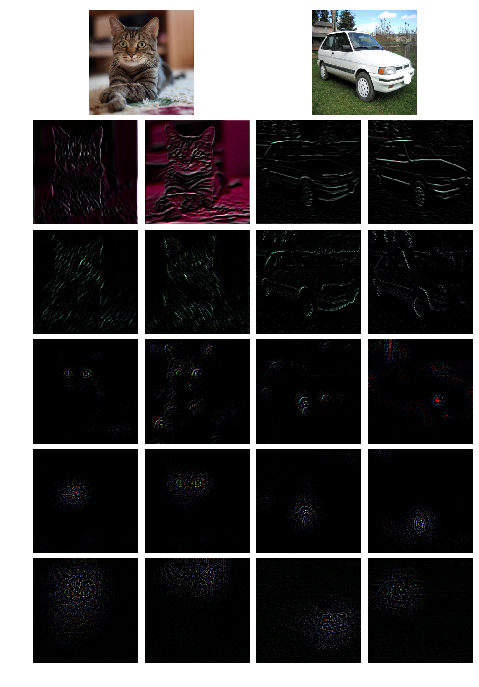

In [165]:
plt.figure(figsize=(8, 12))
plt.subplots_adjust(hspace=0.05, wspace=0)
plt.subplot(6,2,1)
plt.axis("off")
plt.imshow(cat2)
for i in range(5):
    for j in range(2):
        plt.subplot(6,4,4*(i+1)+j+1)
        plt.axis("off")
        plt.imshow(cat2_img[i][j])
plt.subplot(6,2,2)
plt.axis("off")
plt.imshow(car)
for i in range(5):
    for j in range(2):
        plt.subplot(6,4,4*(i+1)+j+3)
        plt.axis("off")
        plt.imshow(car_img[i][j])
plt.show()

Pack this into a smaller image :

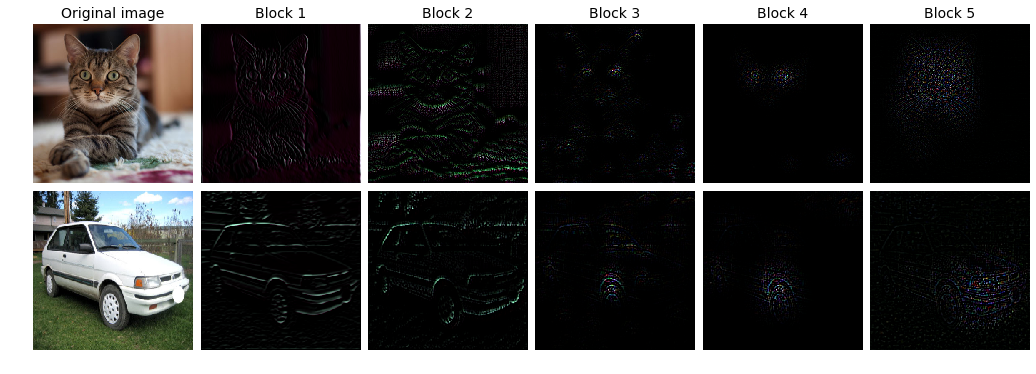

In [28]:
plt.figure(figsize=(18, 6))
plt.subplots_adjust(hspace=0.05, wspace=0)
plt.subplot(2,6,1)
plt.axis("off")
plt.imshow(cat2)
plt.title("Original image", fontsize=14)
for i in range(5):
    plt.subplot(2,6,i+2)
    plt.axis("off")
    plt.imshow(cat2_img[i][0])
    plt.title("Block {}".format(i+1), fontsize=14)
plt.subplot(2,6,7)
plt.axis("off")
plt.imshow(car3)
for i in range(5):
    plt.subplot(2,6,i+8)
    plt.axis("off")
    plt.imshow(car_img[i][0])
plt.show()

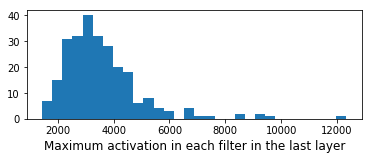

In [52]:
plt.figure(figsize=(6,2))
plt.hist(f0[0,:,:,].max(axis=(0,1)), bins=30)
plt.xlabel("Maximum activation in each filter in the last layer", fontsize=12)
plt.show()

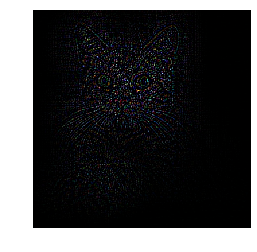

In [42]:
res = reverse_net5.predict(network5.predict(cat2[None]))
plt.imshow(res[0]/res[0].max())
plt.axis("off")
plt.show()